In [1]:
from datasets import SyntheticDataset
from crowd_evaluation import OldEvaluator, ConfidenceEvaluatorC, MajorityEvaluator, VoteAggregator
import numpy as np
import time

In [2]:
from joblib import Memory, Parallel, delayed
memory = Memory('accuracy_interval_vs_confidence_low_error', verbose=0)

@memory.cache
def calc_fraction_of_wrong_interval_estimates(
        num_samples: int,
        num_workers: int,
        confidence: float,
        evaluator_name: str,
        iter_count: int,
        error_rates: list[float]):

    correct_interval_estimates = np.zeros(iter_count * num_workers, dtype=np.float32)
    error_rate_estimation_errors = np.zeros(iter_count * num_workers, dtype=np.float32)
    int_sizes = np.zeros(iter_count * num_workers, dtype=np.float32)

    # Saves for every sample generated whether the
    # majority vote estimates the label correctly (=1) or not (=0)
    majority_vote_estimations = np.zeros(iter_count * num_samples)

    # Saves for every sample generated whether the
    # weighted vote estimates the label correctly (=1) or not (=0)
    weighted_vote_estimations = np.zeros(iter_count * num_samples)

    for i in range(iter_count):
        p_true = np.random.choice(error_rates, size=num_workers)
        dataset = SyntheticDataset(num_samples=num_samples, num_workers=num_workers, p_true=p_true)

        if evaluator_name == 'old':
            evaluator = OldEvaluator(dataset)
            ps, confs = evaluator.evaluate_workers_with_confidence(
                dataset.workers,
                confidence=confidence,
                method='exhaustive'
            )
        elif evaluator_name == 'old greedy':
            evaluator = OldEvaluator(dataset)
            ps, confs = evaluator.evaluate_workers_with_confidence(
                dataset.workers,
                confidence=confidence,
                method='greedy'
            )
        elif evaluator_name == 'majority':
            evaluator = MajorityEvaluator(dataset)
            ps = evaluator.evaluate_workers(dataset.workers)
            confs = np.zeros(num_workers)
        else:
            evaluator = ConfidenceEvaluatorC(dataset)
            ps, confs = evaluator.evaluate_workers_with_confidence(
                dataset.workers,
                confidence=confidence,
            )


        ground_truth = dataset.get_ground_truth_for_samples(dataset.samples)
        maj_vote = VoteAggregator.majority_vote(dataset, dataset.samples)
        weighted_vote = VoteAggregator.weighted_vote(dataset, dataset.samples, ps, 0.5)

        min_limit, max_limit = ps-confs, ps+confs
        correct_interval_estimates[i*num_workers:(i+1)*num_workers] = np.where((min_limit <= p_true) & (p_true <= max_limit), 1, 0)
        int_sizes[i*num_workers:(i+1)*num_workers] = 2*confs
        error_rate_estimation_errors[i*num_workers:(i+1)*num_workers] = np.abs(ps - p_true)

        majority_vote_estimations[i*num_samples:(i+1)*num_samples] = (ground_truth == maj_vote)
        weighted_vote_estimations[i*num_samples:(i+1)*num_samples] = (ground_truth == weighted_vote)

    return correct_interval_estimates, int_sizes, error_rate_estimation_errors, majority_vote_estimations, weighted_vote_estimations

In [3]:
from visualizations.utils import say
from tqdm import tqdm
import time

start = time.time()

confidence_levels = np.arange(0, 1, 0.05)

# num_workers/num_samples configurations to analyze
configurations = [(3, 300), (7, 300), (3, 100), (7, 100)]
iteration_count = 500
evaluater_names = ['new', 'old greedy']
# error_rates = [0.1, 0.2, 0.3]
error_rates = [0.1, 0.08, 0.06]

# Stores whether the interval contained the true error rate for every dataset.
correct_interval_estimates = dict()

# Stores the average accuracy for every configuration.
accuracies = dict()

# Stores all measured interval sizes for every dataset
interval_sizes = dict()

# Stores the average interval sizes for every configuration
average_interval_sizes = dict()

# Stores all estimation error for every dataset
estimation_errors = dict()

# Stores the average estimation error for every configuration
average_estimation_errors = dict()

majority_vote_estimation_accuracies = dict()

weighted_vote_estimation_accuracies = dict()

for num_workers, num_samples in configurations:
    # n: num_samples
    # m: num_workers
    correct_interval_estimates[(num_samples, num_workers)] = dict()
    accuracies[(num_samples, num_workers)] = dict()
    interval_sizes[(num_samples, num_workers)] = dict()
    average_interval_sizes[(num_samples, num_workers)] = dict()
    estimation_errors[(num_samples, num_workers)] = dict()
    average_estimation_errors[(num_samples, num_workers)] = dict()
    majority_vote_estimation_accuracies[(num_samples, num_workers)] = dict()
    weighted_vote_estimation_accuracies[(num_samples, num_workers)] = dict()

    for t in evaluater_names:
        print('num_workers: ' + str(num_workers) + ', num_tasks: ' + str(num_samples) + ', evaluator: ' + t)
        res = Parallel(n_jobs=7)(delayed(calc_fraction_of_wrong_interval_estimates)
                (num_samples, num_workers, c, t, iteration_count, error_rates) for c in tqdm(confidence_levels))

        correct_interval_estimates_results = np.array([x[0] for x in res])
        interval_sizes_results = np.array([x[1] for x in res])
        est_errs_results = np.array([x[2] for x in res])
        maj_vote_results = np.array([x[3] for x in res])
        weighted_vote_results = np.array([x[4] for x in res])

        accuracies[(num_samples, num_workers)][t] = np.array([np.sum(correct_interval_estimates_results[i]) for i in range(len(confidence_levels))]) / (num_workers * iteration_count)
        correct_interval_estimates[(num_samples, num_workers)][t] = correct_interval_estimates_results
        interval_sizes[(num_samples, num_workers)][t] = interval_sizes_results
        average_interval_sizes[(num_samples, num_workers)][t] = np.array([np.mean(interval_sizes_results[i]) for i in range(len(confidence_levels))])
        estimation_errors[(num_samples, num_workers)][t] = est_errs_results
        average_estimation_errors[(num_samples, num_workers)][t] = np.array([np.mean(est_errs_results[i]) for i in range(len(confidence_levels))])
        majority_vote_estimation_accuracies[(num_samples, num_workers)][t] = np.array([np.mean(maj_vote_results[i]) for i in range(len(confidence_levels))])
        weighted_vote_estimation_accuracies[(num_samples, num_workers)][t] = np.array([np.mean(weighted_vote_results[i]) for i in range(len(confidence_levels))])

end = time.time()
print('Time elapsed:', end-start)
say("Accuracy and interval size vs confidence calculations completed")

num_workers: 3, num_tasks: 300, evaluator: new


100%|██████████| 20/20 [05:47<00:00, 17.38s/it]


num_workers: 3, num_tasks: 300, evaluator: old greedy


100%|██████████| 20/20 [05:53<00:00, 17.65s/it]


num_workers: 7, num_tasks: 300, evaluator: new


100%|██████████| 20/20 [17:53<00:00, 53.66s/it]


num_workers: 7, num_tasks: 300, evaluator: old greedy


100%|██████████| 20/20 [05:09<00:00, 15.49s/it]


num_workers: 3, num_tasks: 100, evaluator: new


100%|██████████| 20/20 [01:41<00:00,  5.09s/it]


num_workers: 3, num_tasks: 100, evaluator: old greedy


100%|██████████| 20/20 [01:31<00:00,  4.55s/it]


num_workers: 7, num_tasks: 100, evaluator: new


100%|██████████| 20/20 [10:13<00:00, 30.65s/it]


num_workers: 7, num_tasks: 100, evaluator: old greedy


100%|██████████| 20/20 [02:11<00:00,  6.55s/it]


Time elapsed: 8710.844241142273


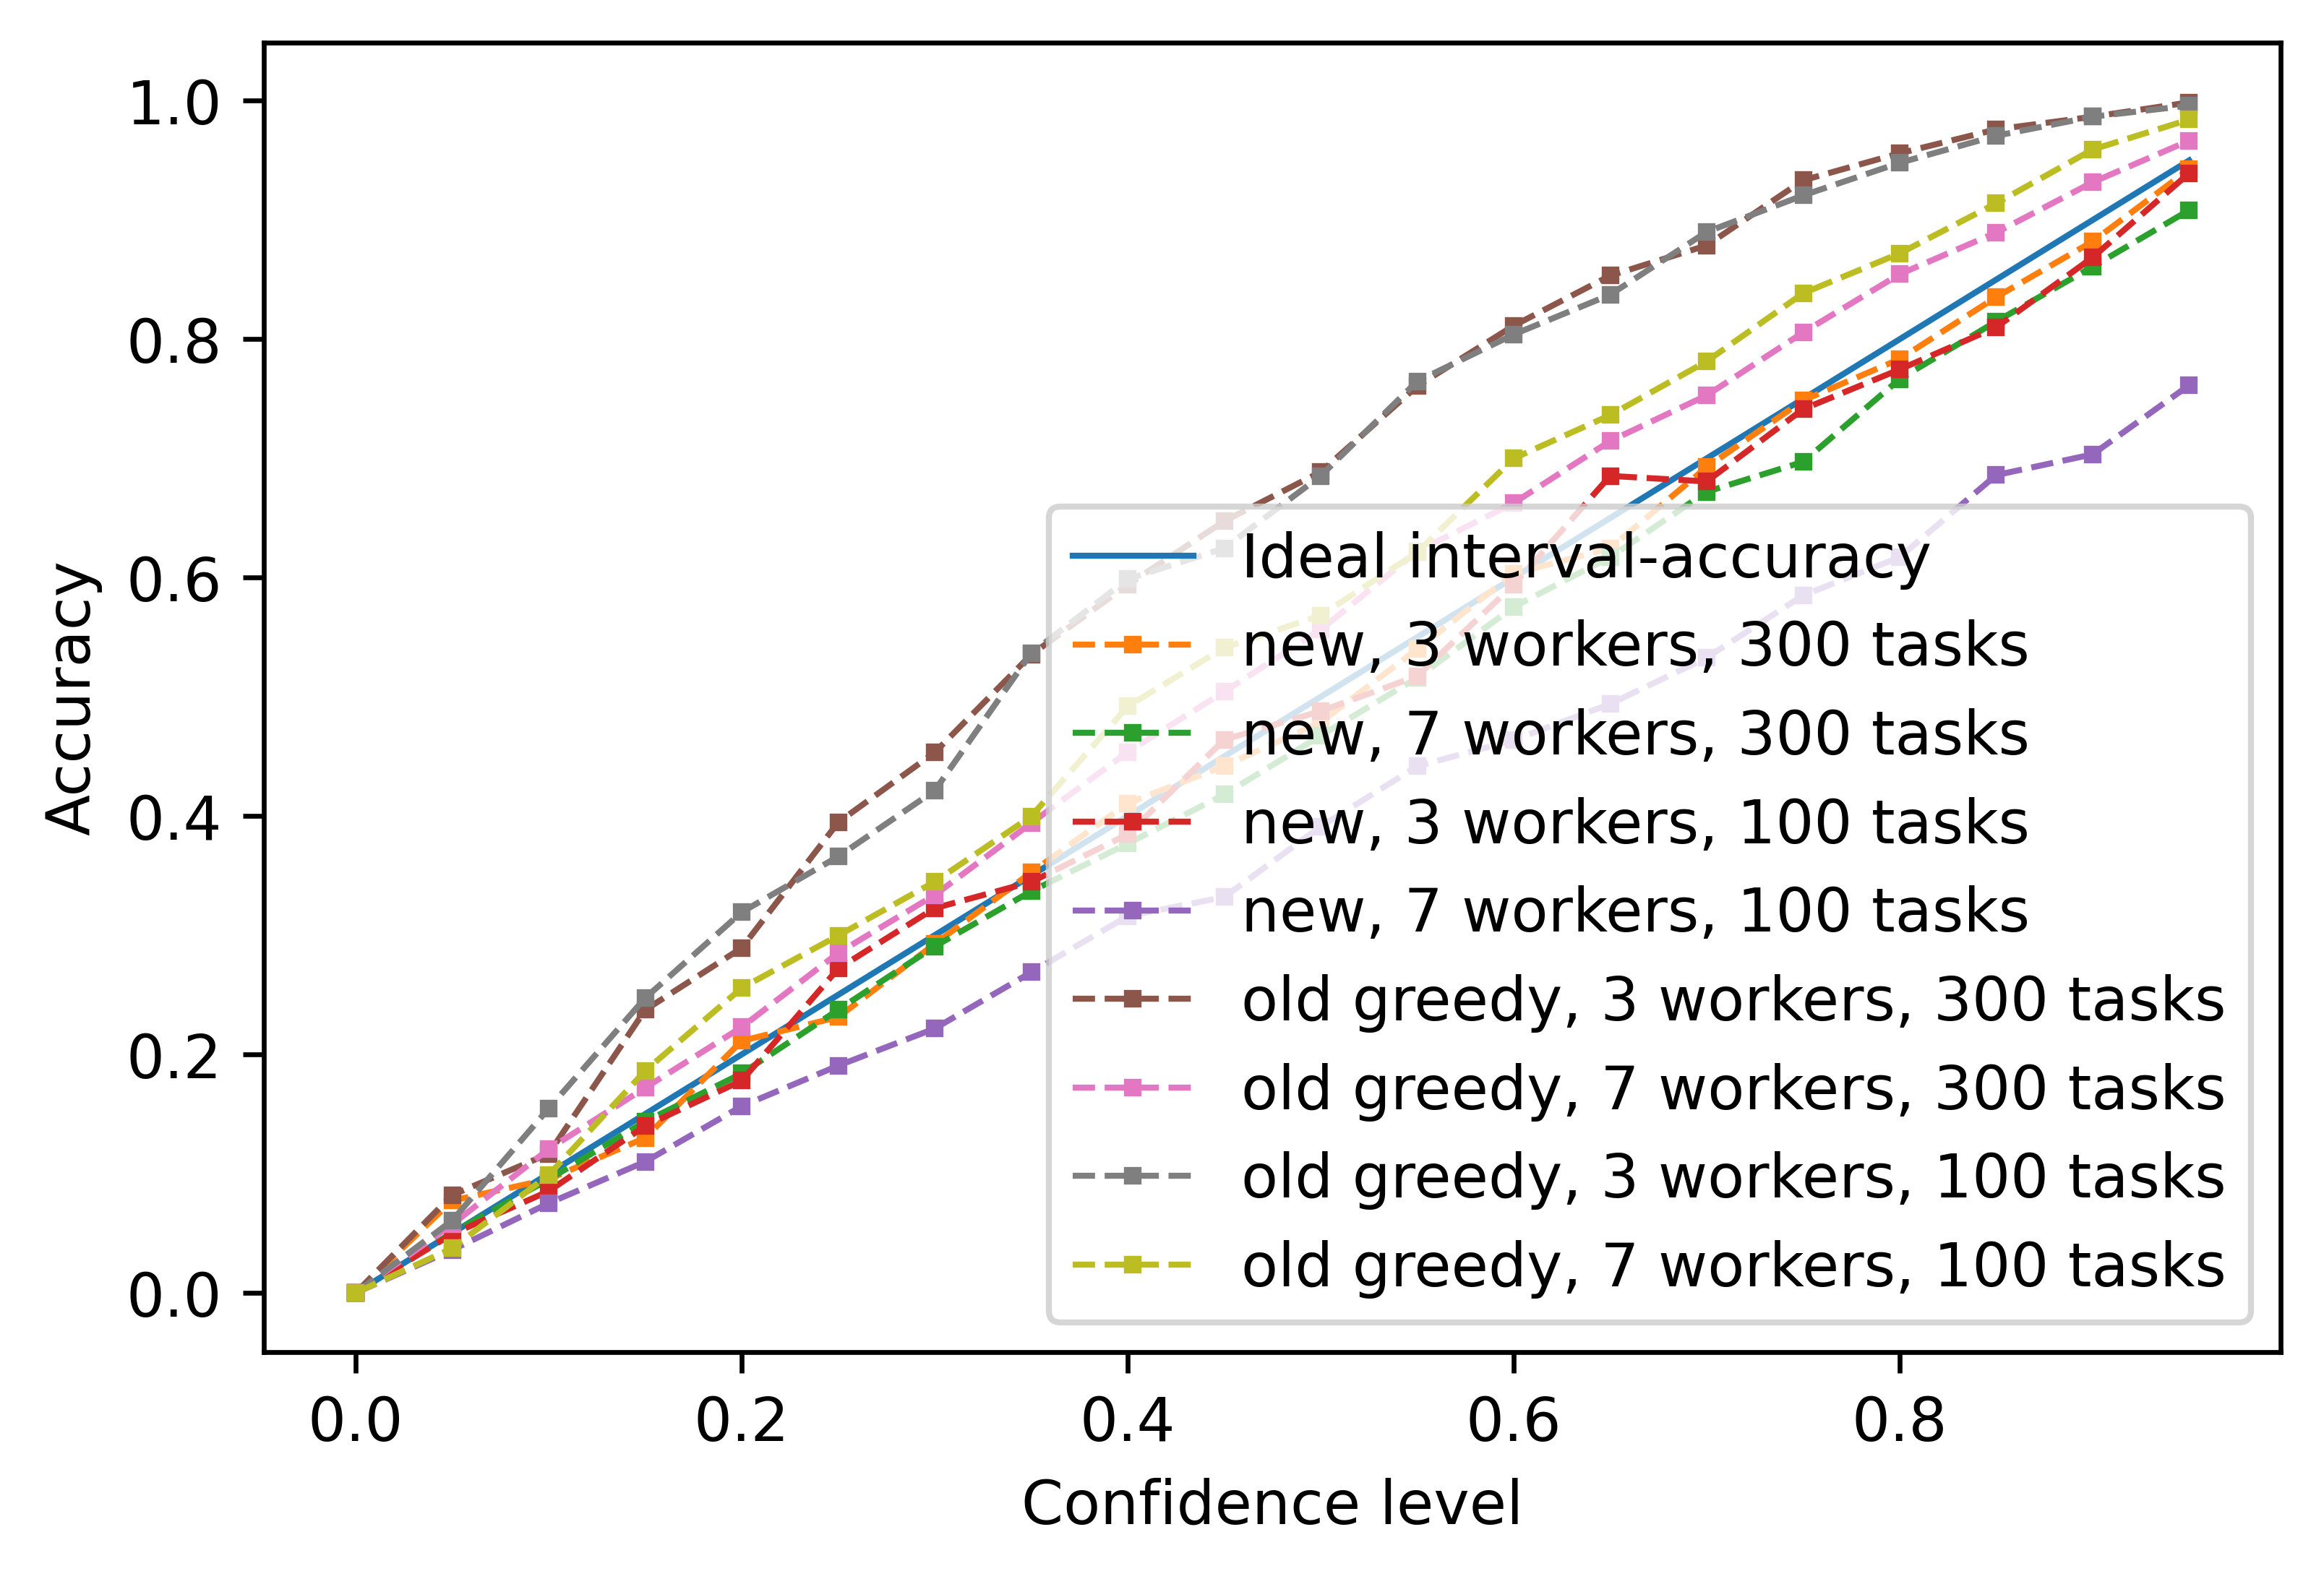

In [4]:
import matplotlib.pyplot as plt
import matplotlib as mpl
%matplotlib inline

mpl.rcParams['figure.dpi'] = 600

plt.plot(confidence_levels, confidence_levels, label='Ideal interval-accuracy', linewidth=1)
for t in evaluater_names:
    for num_workers, num_samples in configurations:
        # n: num_samples
        # m: num_workers
        plt.plot(confidence_levels, accuracies[(num_samples, num_workers)][t], marker='s', linestyle='--',
                 label =t +', ' + str(num_workers) + ' workers, ' + str(num_samples) + ' tasks', linewidth=1, markersize=2)

plt.xlabel('Confidence level')
plt.ylabel('Accuracy')
plt.legend()
plt.show()
# plt.savefig('confidence_vs_accuracy.svg')

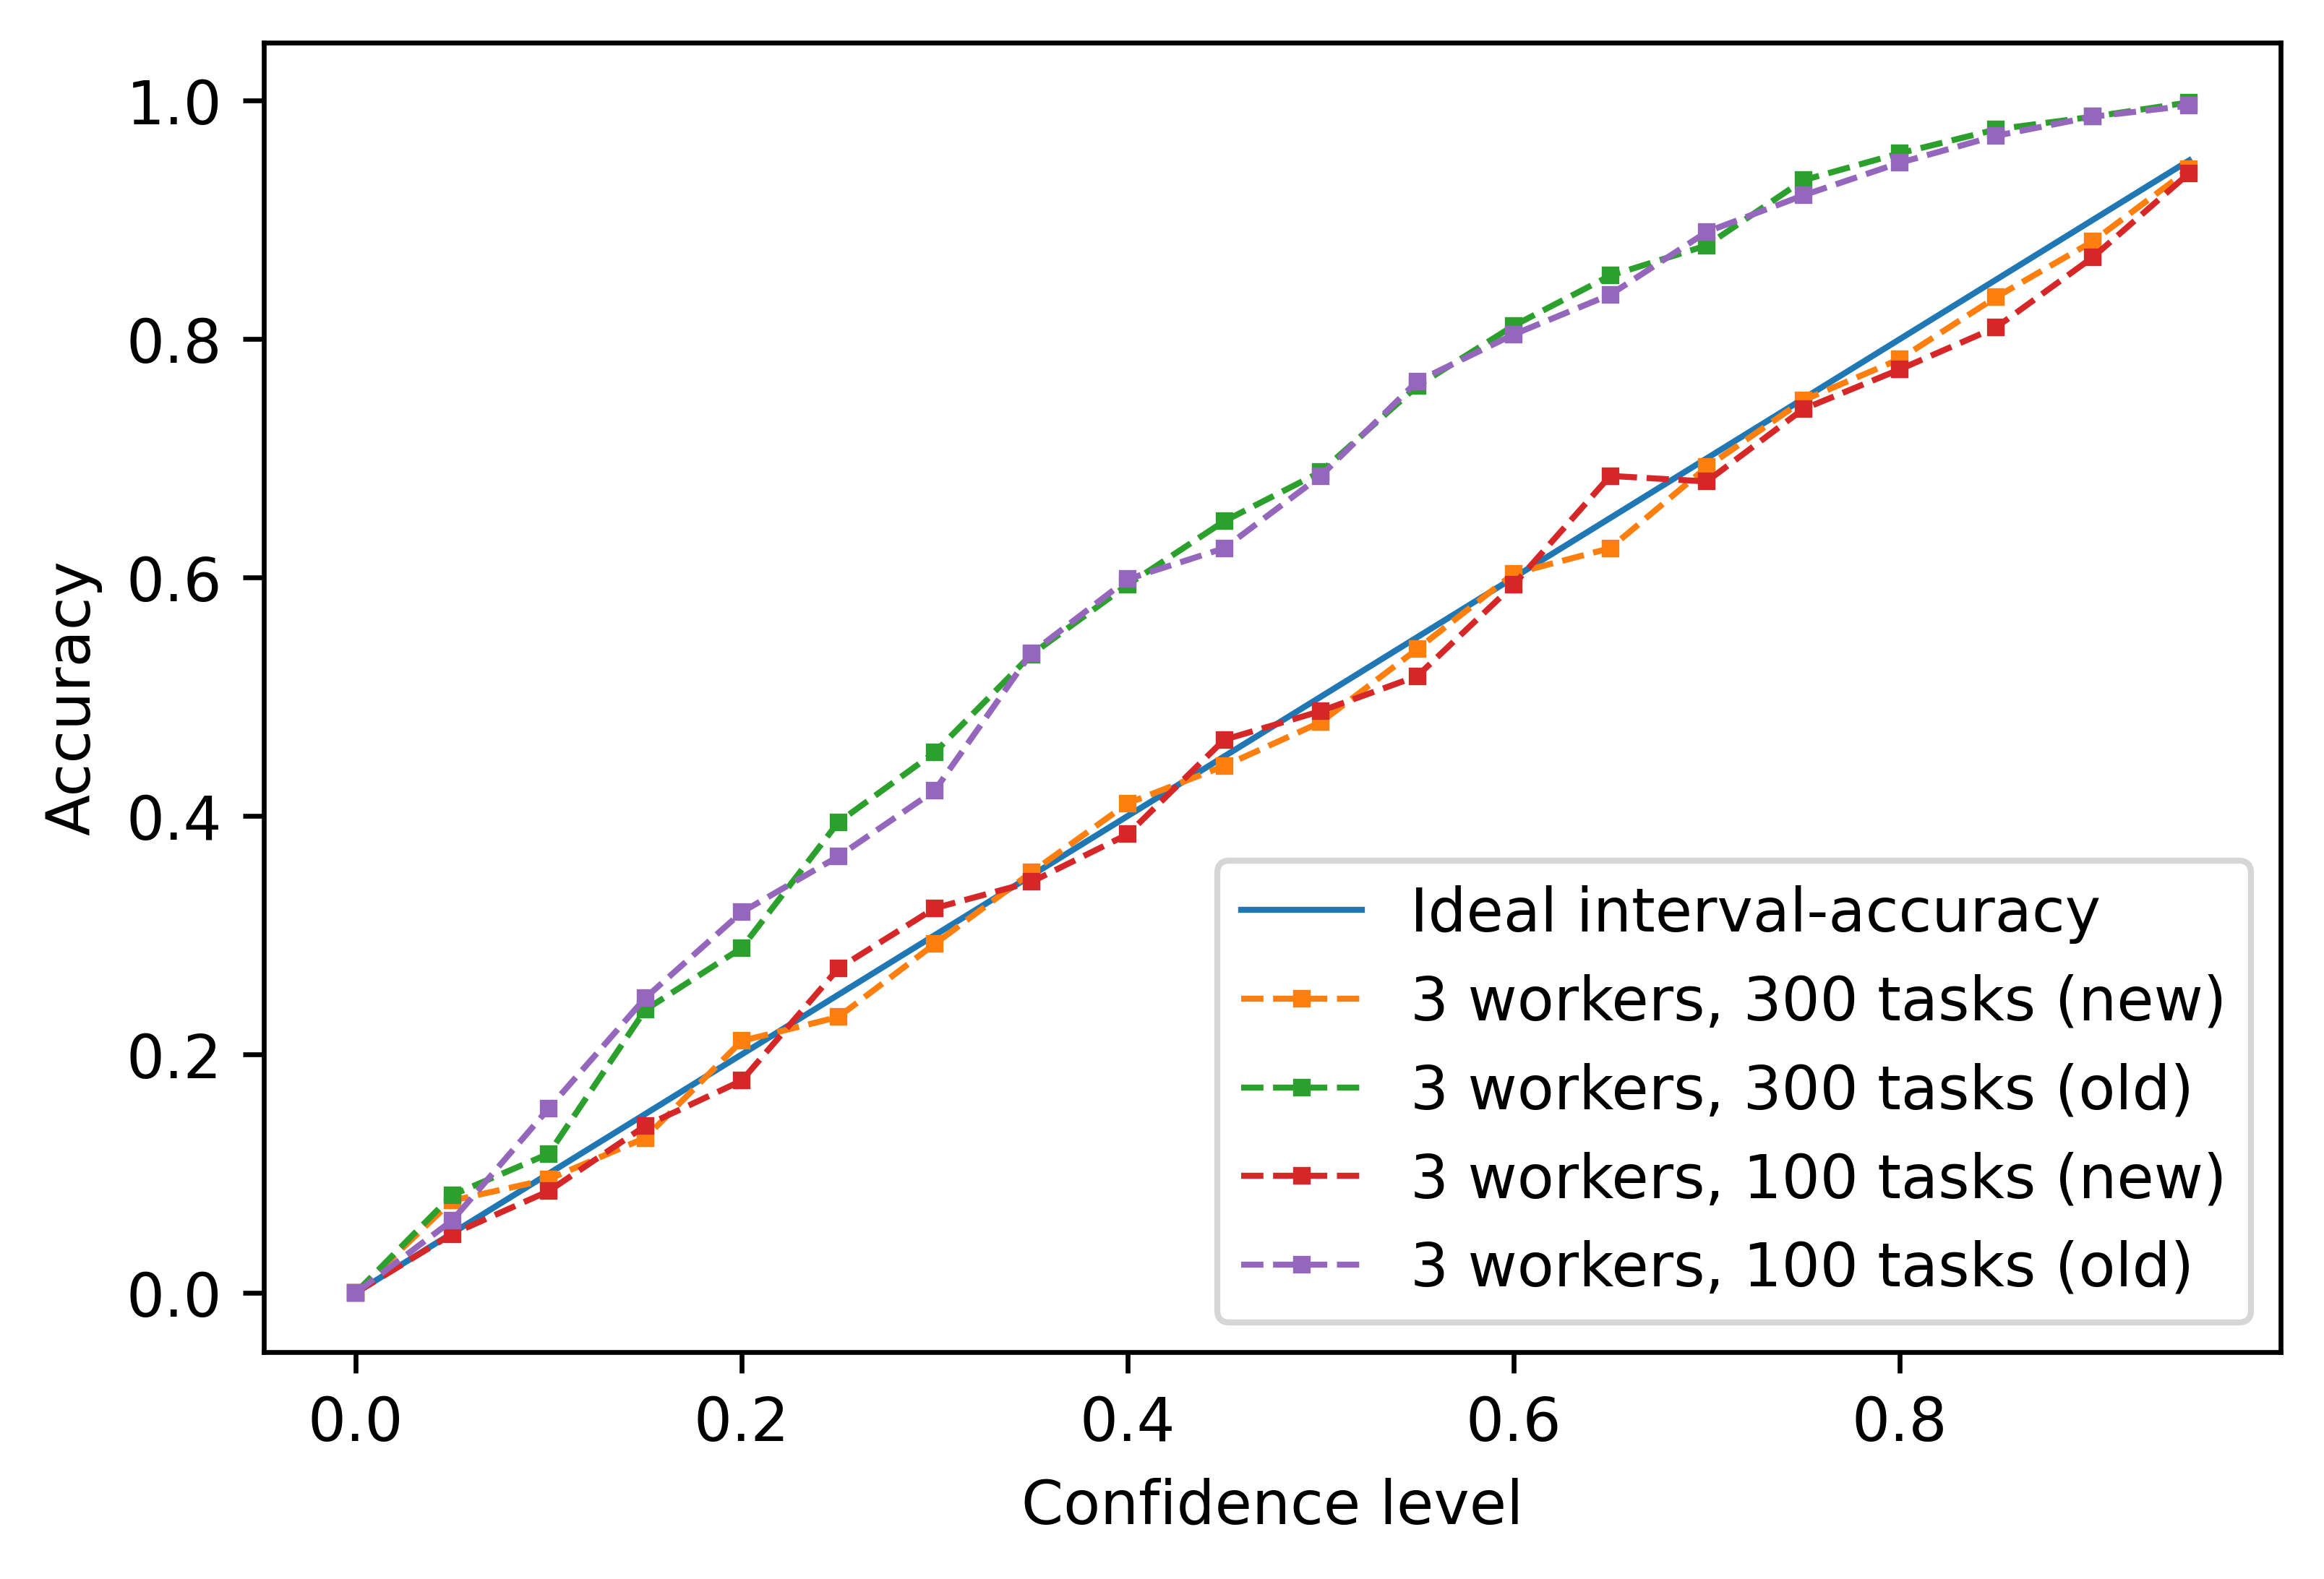

In [5]:
import matplotlib.pyplot as plt
import matplotlib as mpl
%matplotlib inline

mpl.rcParams['figure.dpi'] = 600

plt.plot(confidence_levels, confidence_levels, label='Ideal interval-accuracy', linewidth=1)

plt.plot(confidence_levels, accuracies[(300, 3)]['new'], marker='s', linestyle='--',
             label = '3 workers, 300 tasks (new)', linewidth=1, markersize=2)
# plt.plot(confidence_levels, accuracies[(300, 7)]['new'], marker='s', linestyle='--',
#              label = '7 workers, 300 tasks', linewidth=1, markersize=2)
plt.plot(confidence_levels, accuracies[(300, 3)]['old greedy'], marker='s', linestyle='--',
             label = '3 workers, 300 tasks (old)', linewidth=1, markersize=2)

plt.plot(confidence_levels, accuracies[(100, 3)]['new'], marker='s', linestyle='--',
             label = '3 workers, 100 tasks (new)', linewidth=1, markersize=2)
plt.plot(confidence_levels, accuracies[(100, 3)]['old greedy'], marker='s', linestyle='--',
             label = '3 workers, 100 tasks (old)', linewidth=1, markersize=2)

# plt.plot(confidence_levels, confidence_levels - accuracies[(300, 7)]['new'], marker='s', linestyle='--',
#              label = '7 workers, 300 tasks', linewidth=1, markersize=2)

plt.xlabel('Confidence level')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

In [6]:
accuracies[(300, 7)]['new'][-1]

0.90828574

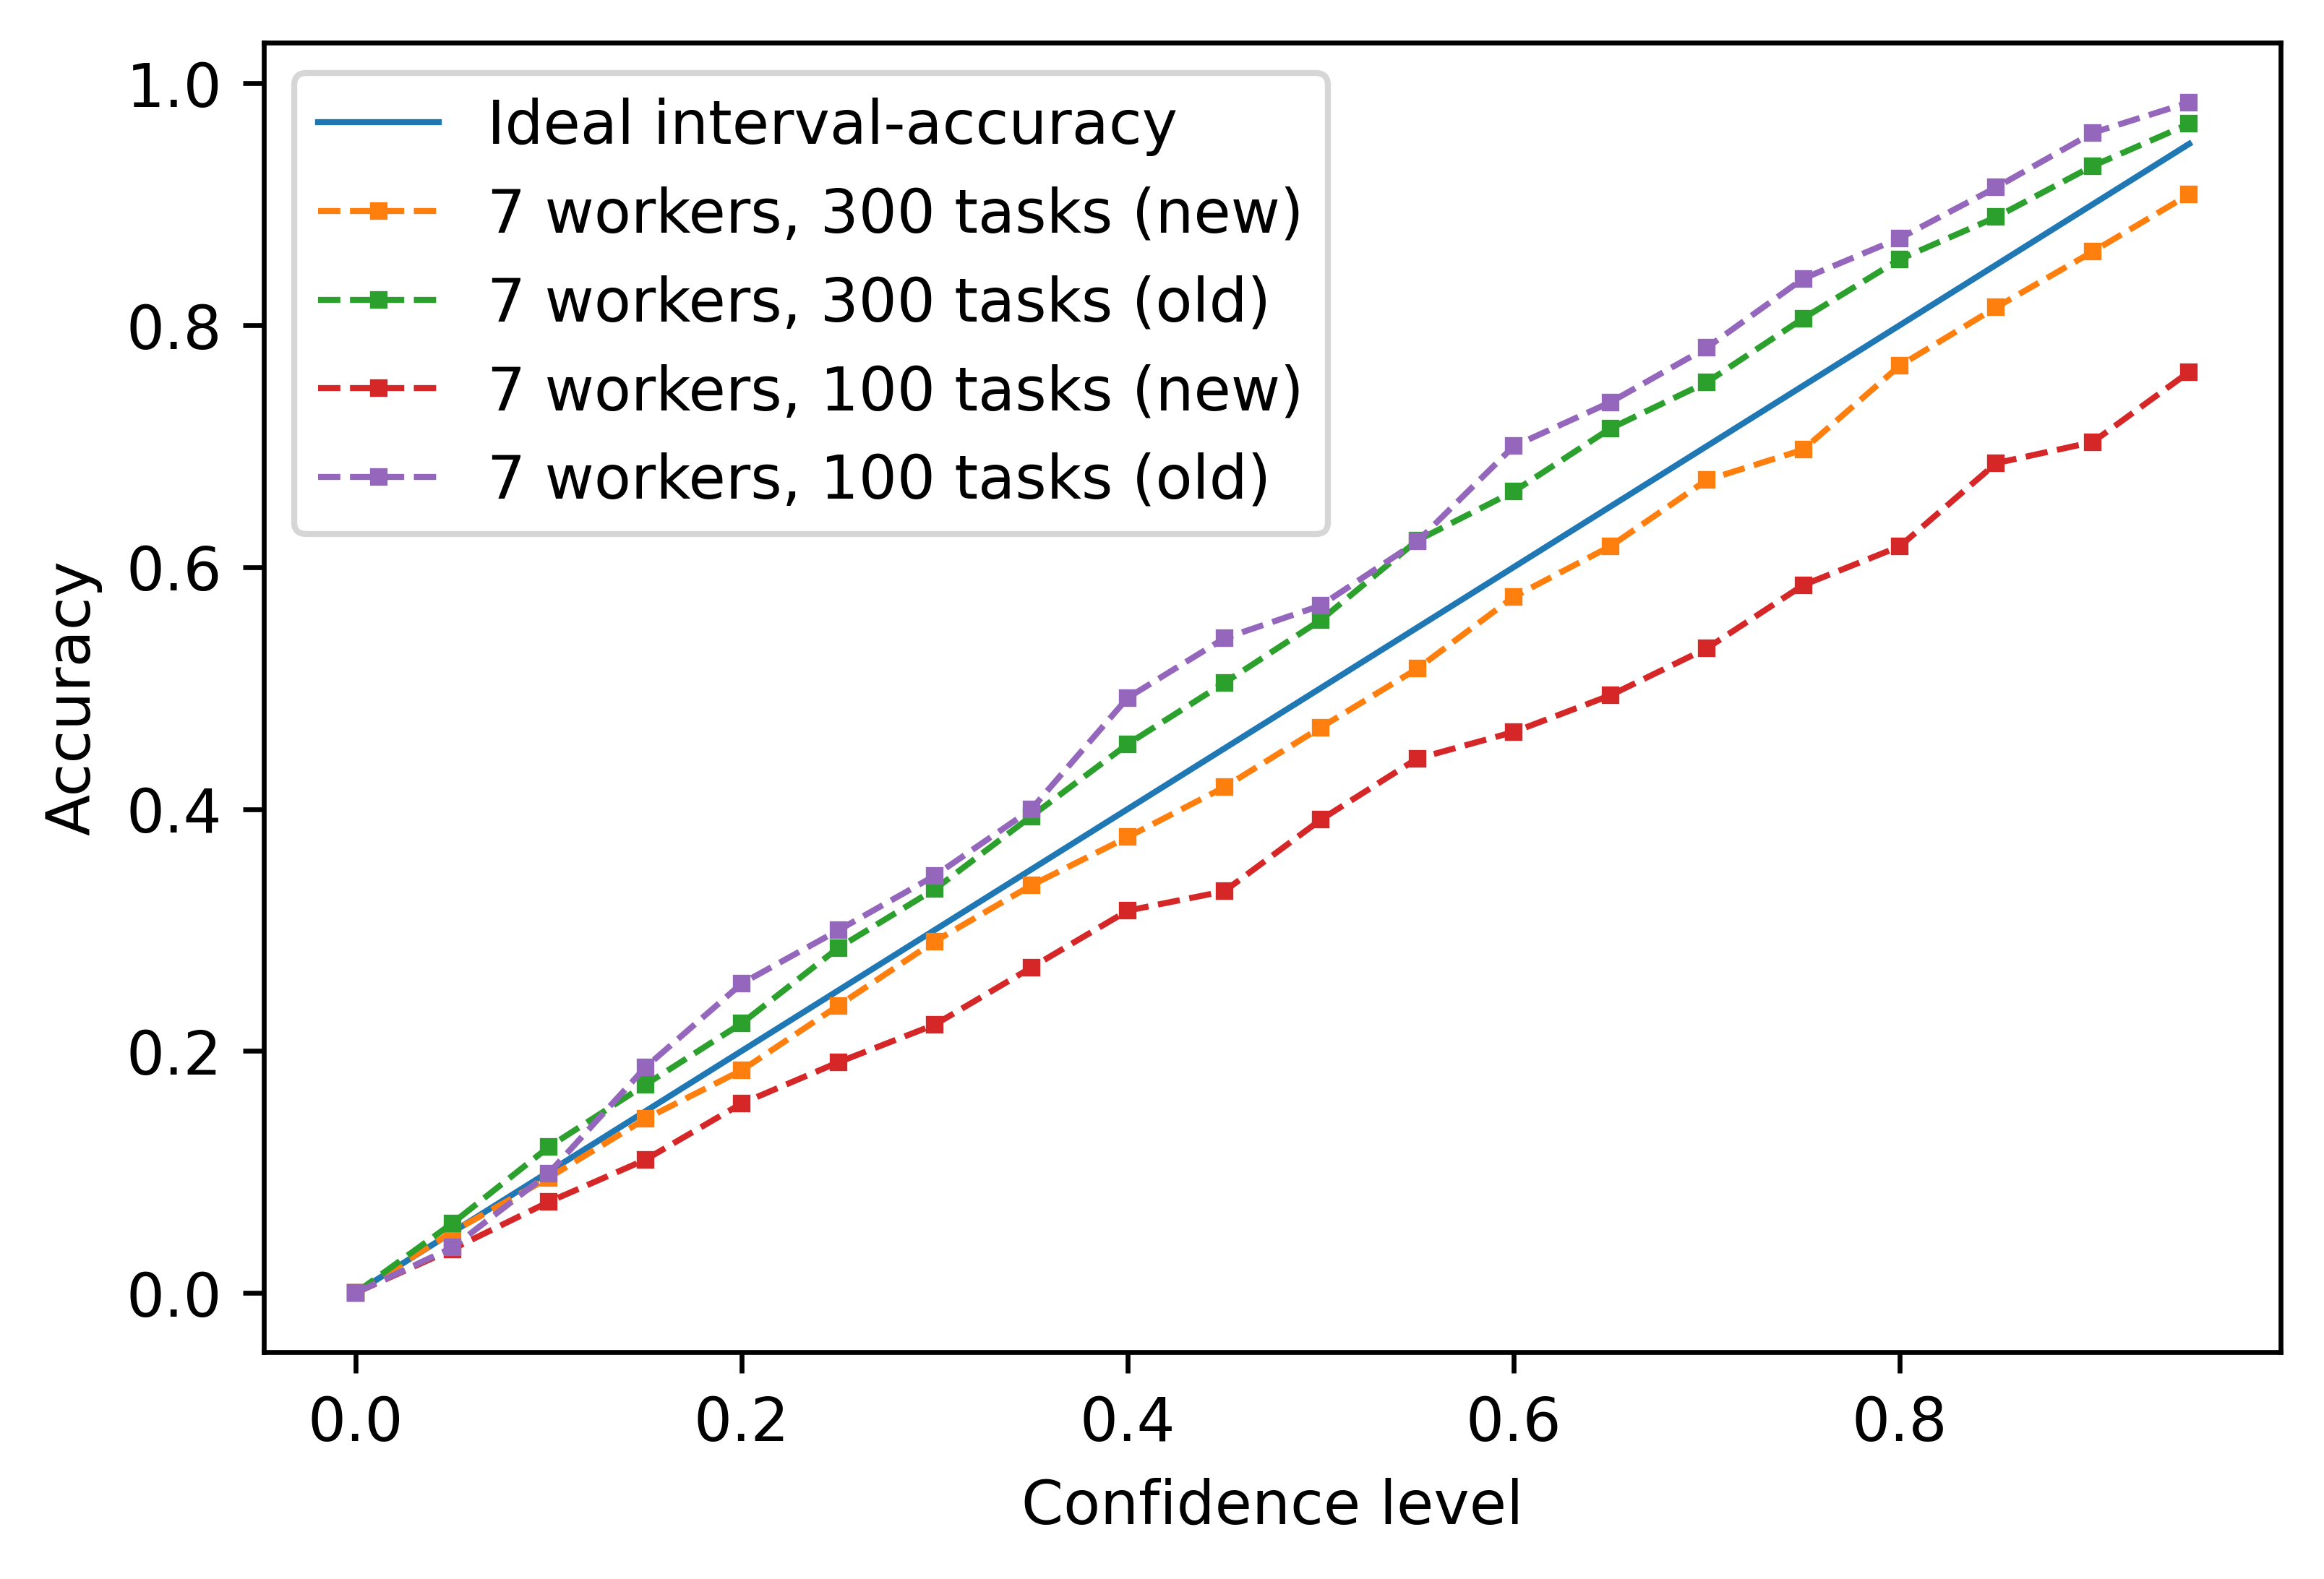

In [7]:
plt.plot(confidence_levels, confidence_levels, label='Ideal interval-accuracy', linewidth=1)

plt.plot(confidence_levels, accuracies[(300, 7)]['new'], marker='s', linestyle='--',
             label = '7 workers, 300 tasks (new)', linewidth=1, markersize=2)
plt.plot(confidence_levels, accuracies[(300, 7)]['old greedy'], marker='s', linestyle='--',
             label = '7 workers, 300 tasks (old)', linewidth=1, markersize=2)

plt.plot(confidence_levels, accuracies[(100, 7)]['new'], marker='s', linestyle='--',
             label = '7 workers, 100 tasks (new)', linewidth=1, markersize=2)
plt.plot(confidence_levels, accuracies[(100, 7)]['old greedy'], marker='s', linestyle='--',
             label = '7 workers, 100 tasks (old)', linewidth=1, markersize=2)

# plt.plot(confidence_levels, confidence_levels - accuracies[(300, 7)]['new'], marker='s', linestyle='--',
#              label = '7 workers, 300 tasks', linewidth=1, markersize=2)

plt.xlabel('Confidence level')
plt.ylabel('Accuracy')
plt.legend()
plt.show()



In [8]:
result = np.array(interval_sizes[(300, 3)]['new'][1:]) / np.array(interval_sizes[(300, 3)]['old greedy'][1:])
np.mean(result)

0.64585817

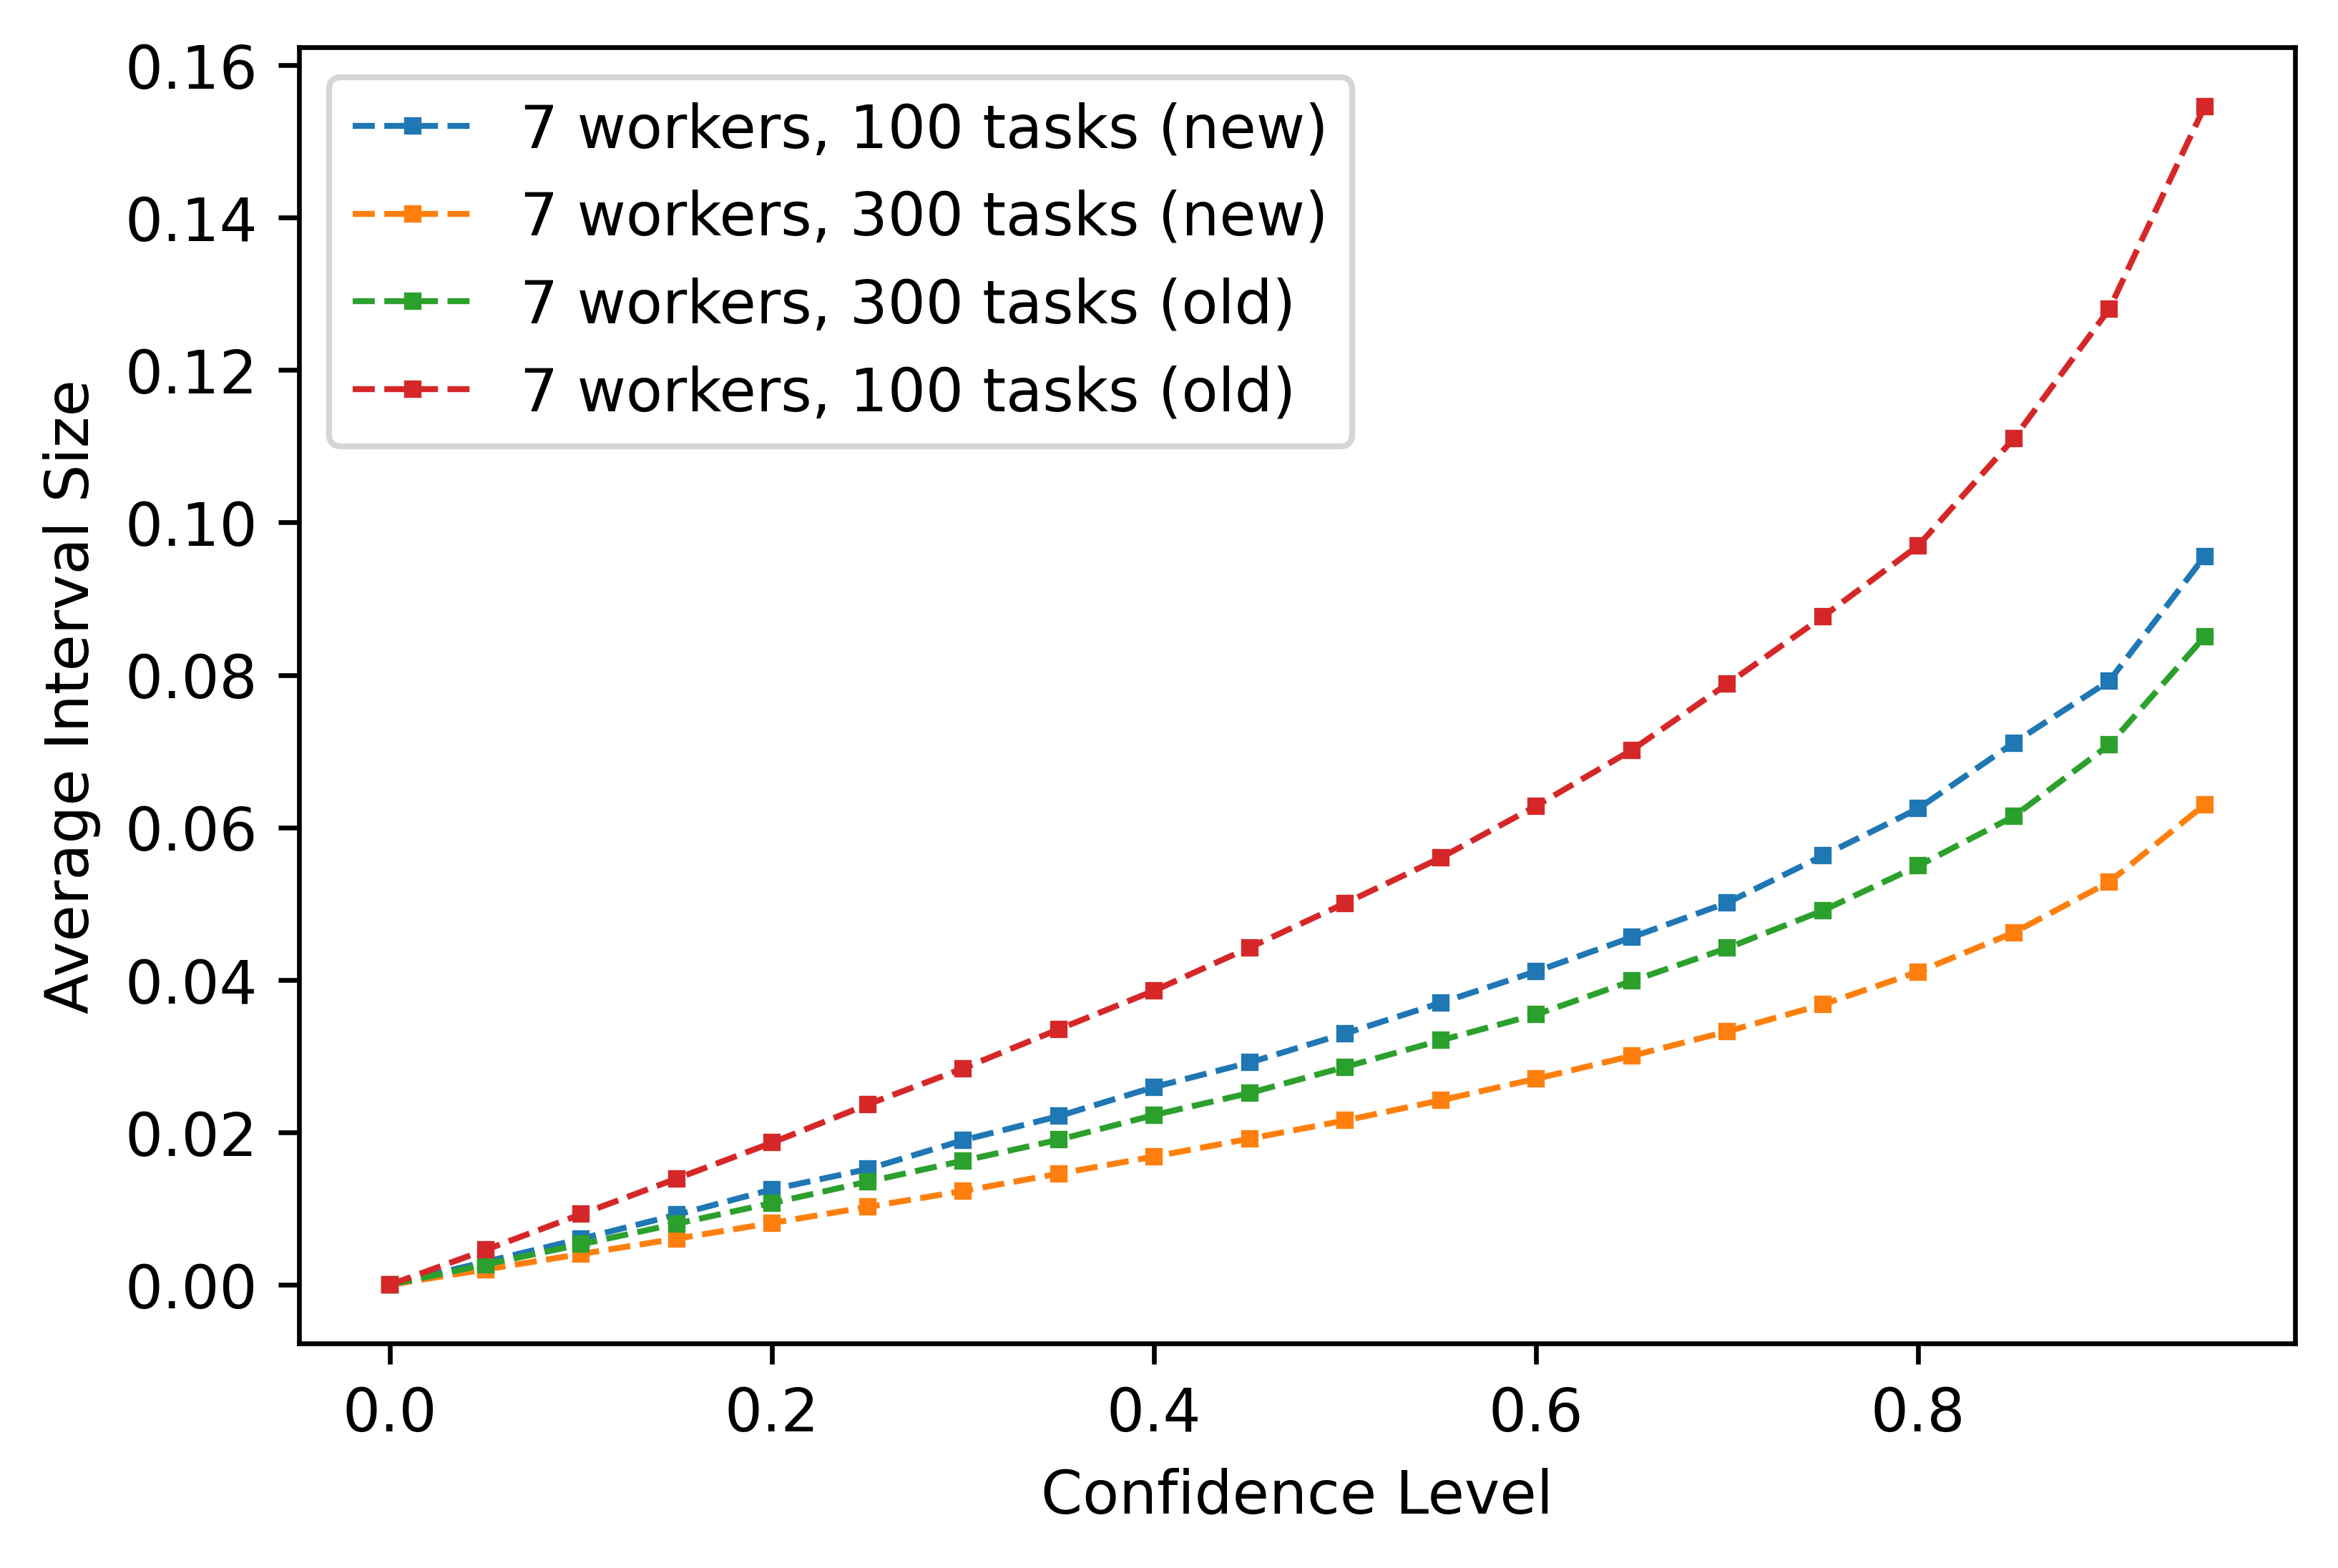

<Figure size 3600x2400 with 0 Axes>

In [9]:
plt.plot(confidence_levels, average_interval_sizes[(100, 7)]['new'], marker='s', linestyle='--',
                 label ='7 workers, 100 tasks (new)', linewidth=1, markersize=2)
plt.plot(confidence_levels, average_interval_sizes[(300, 7)]['new'], marker='s', linestyle='--',
                 label ='7 workers, 300 tasks (new)', linewidth=1, markersize=2)

plt.plot(confidence_levels, average_interval_sizes[(300, 7)]['old greedy'], marker='s', linestyle='--',
                 label ='7 workers, 300 tasks (old)', linewidth=1, markersize=2)
plt.plot(confidence_levels, average_interval_sizes[(100, 7)]['old greedy'], marker='s', linestyle='--',
                 label ='7 workers, 100 tasks (old)', linewidth=1, markersize=2)

plt.xlabel('Confidence Level')
plt.ylabel('Average Interval Size')
plt.legend()
plt.show()
plt.savefig('confidence_vs_interval_size_7_workers.png')

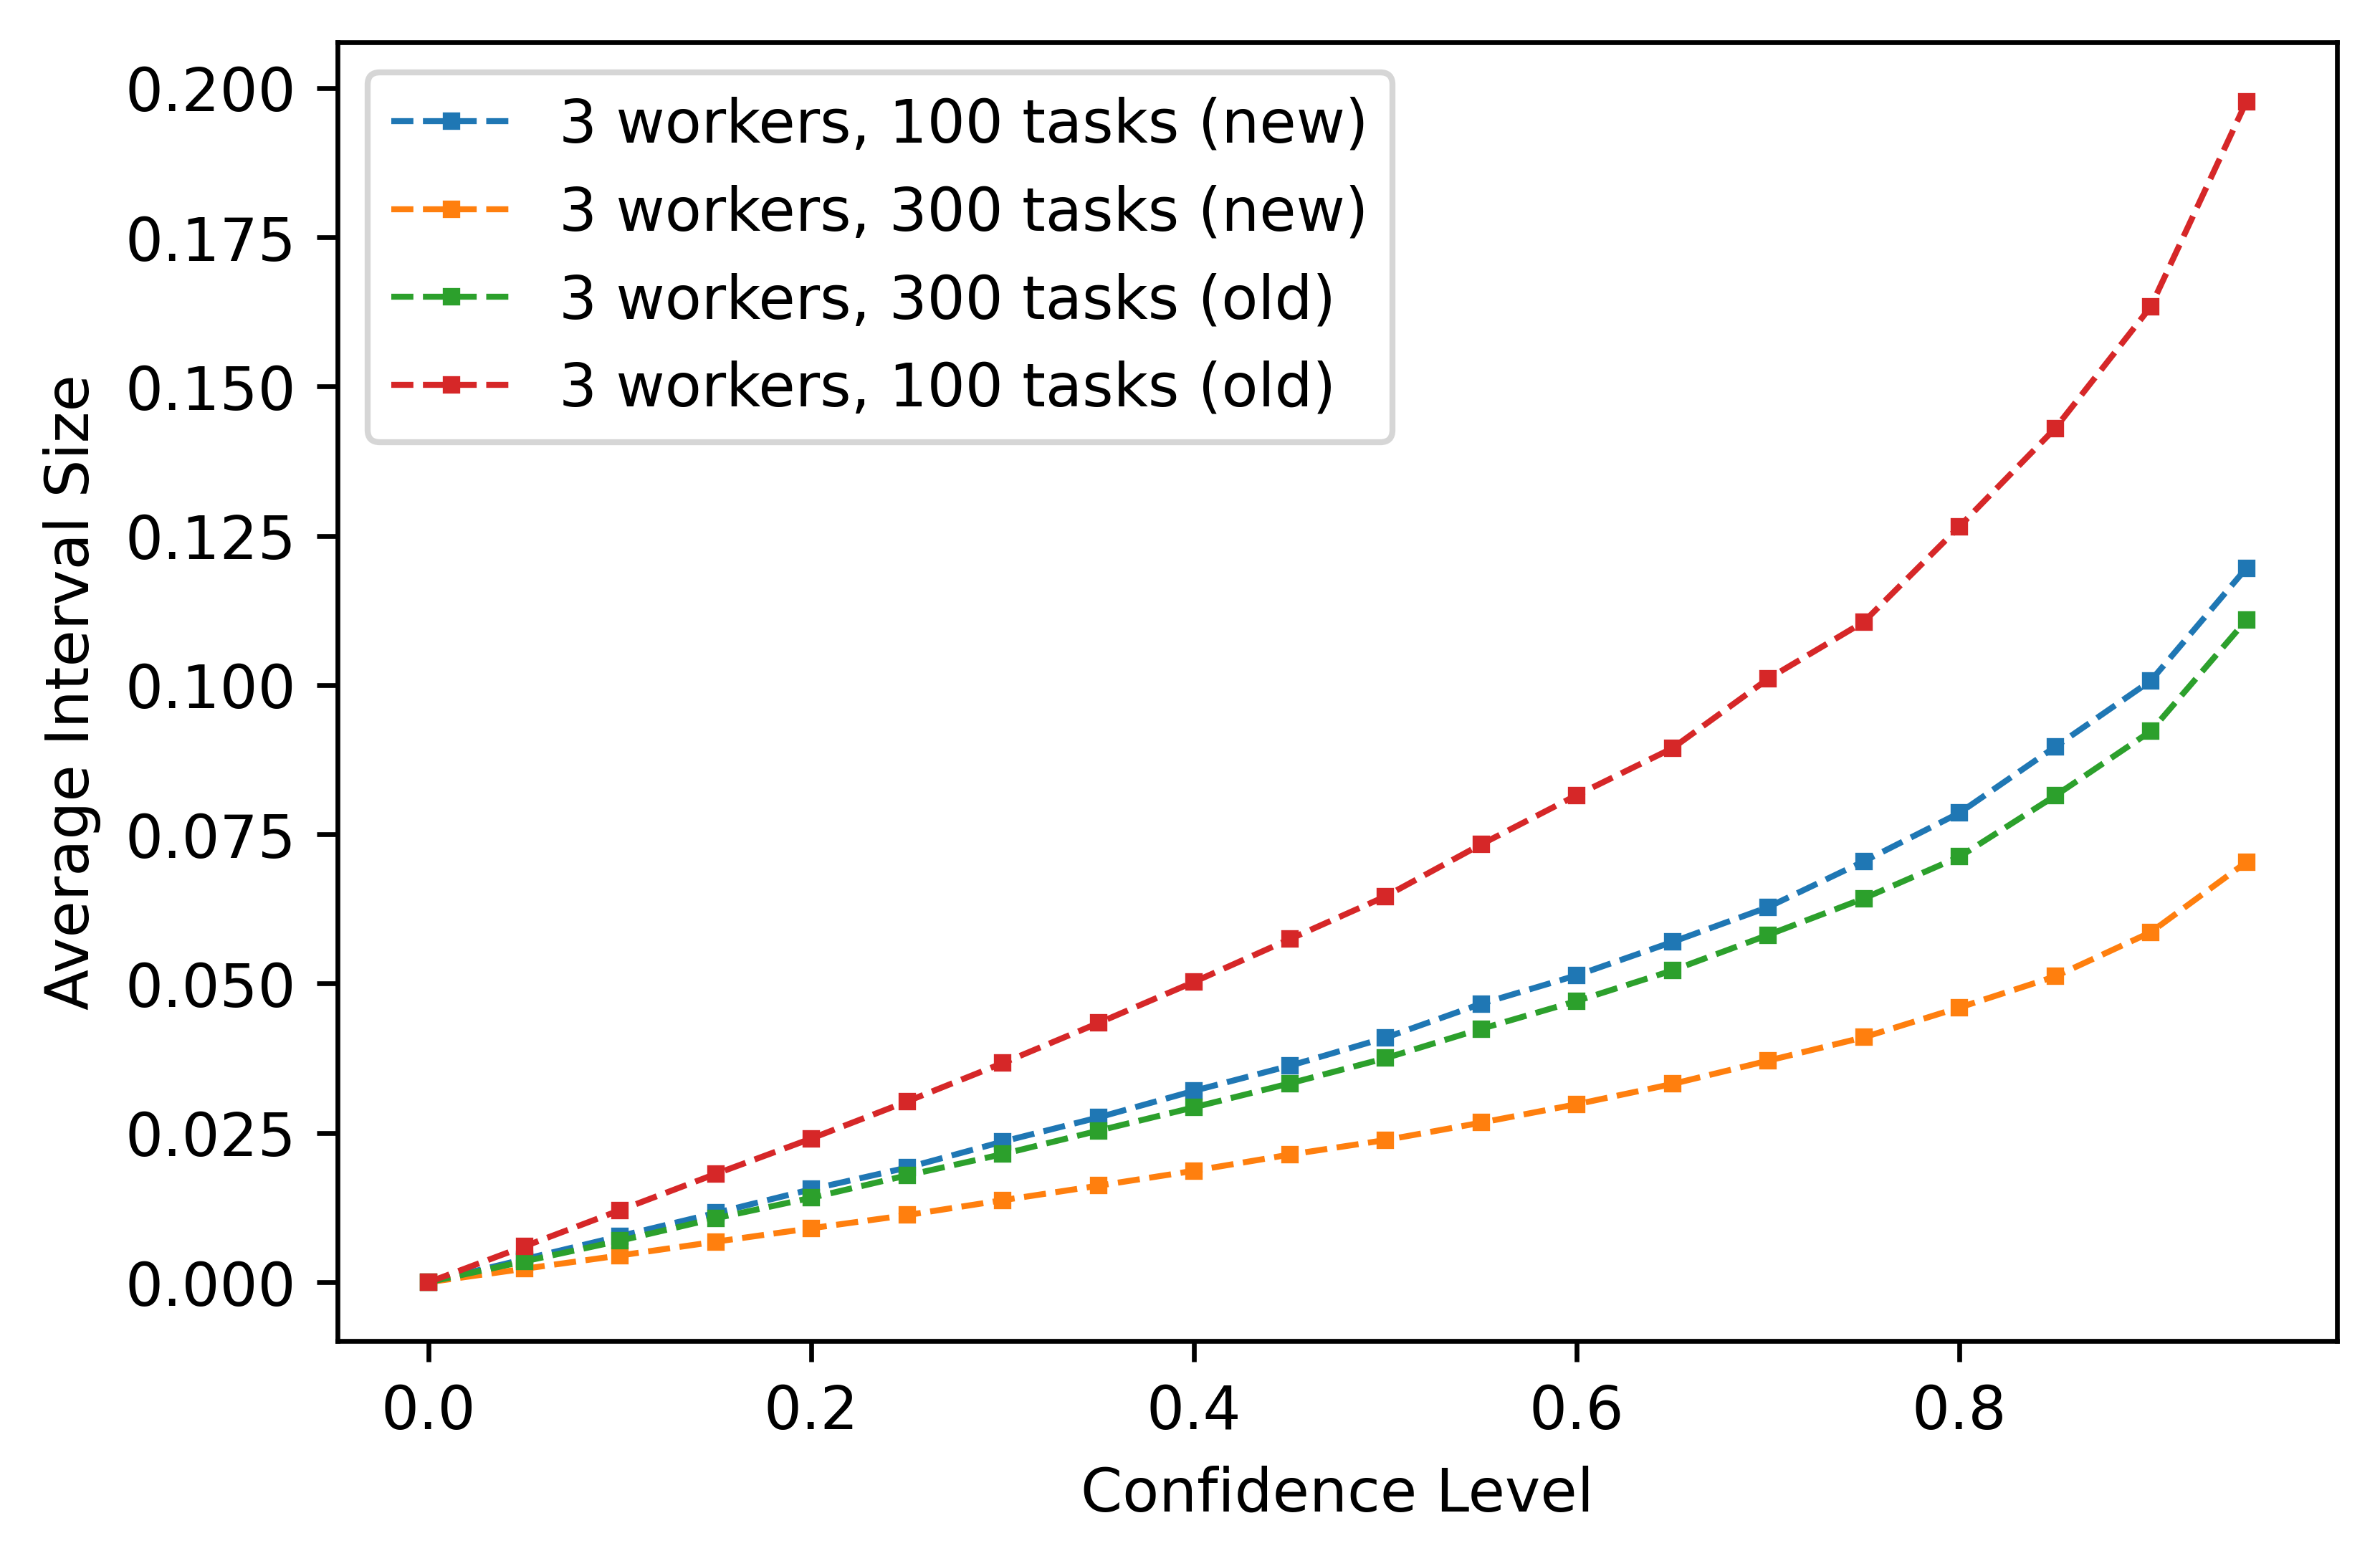

<Figure size 3600x2400 with 0 Axes>

In [10]:

plt.plot(confidence_levels, average_interval_sizes[(100, 3)]['new'], marker='s', linestyle='--',
                 label ='3 workers, 100 tasks (new)', linewidth=1, markersize=2)
plt.plot(confidence_levels, average_interval_sizes[(300, 3)]['new'], marker='s', linestyle='--',
                 label ='3 workers, 300 tasks (new)', linewidth=1, markersize=2)

plt.plot(confidence_levels, average_interval_sizes[(300, 3)]['old greedy'], marker='s', linestyle='--',
                 label ='3 workers, 300 tasks (old)', linewidth=1, markersize=2)
plt.plot(confidence_levels, average_interval_sizes[(100, 3)]['old greedy'], marker='s', linestyle='--',
                 label ='3 workers, 100 tasks (old)', linewidth=1, markersize=2)

plt.xlabel('Confidence Level')
plt.ylabel('Average Interval Size')
plt.legend()
plt.show()
plt.savefig('confidence_vs_interval_size_3_workers.png')

/var/folders/qw/p4qgsv7j73v58mh52m6kcw6w0000gn/T/ipykernel_3203/3650340377.py:2: RuntimeWarning: invalid value encountered in true_divide
  average_interval_sizes[(100, 3)]['new'] / average_interval_sizes[(100, 3)]['old greedy'],
/var/folders/qw/p4qgsv7j73v58mh52m6kcw6w0000gn/T/ipykernel_3203/3650340377.py:6: RuntimeWarning: invalid value encountered in true_divide
  average_interval_sizes[(300, 3)]['new'] / average_interval_sizes[(300, 3)]['old greedy'],


Text(0, 0.5, 'fractional interval size new/old technique')

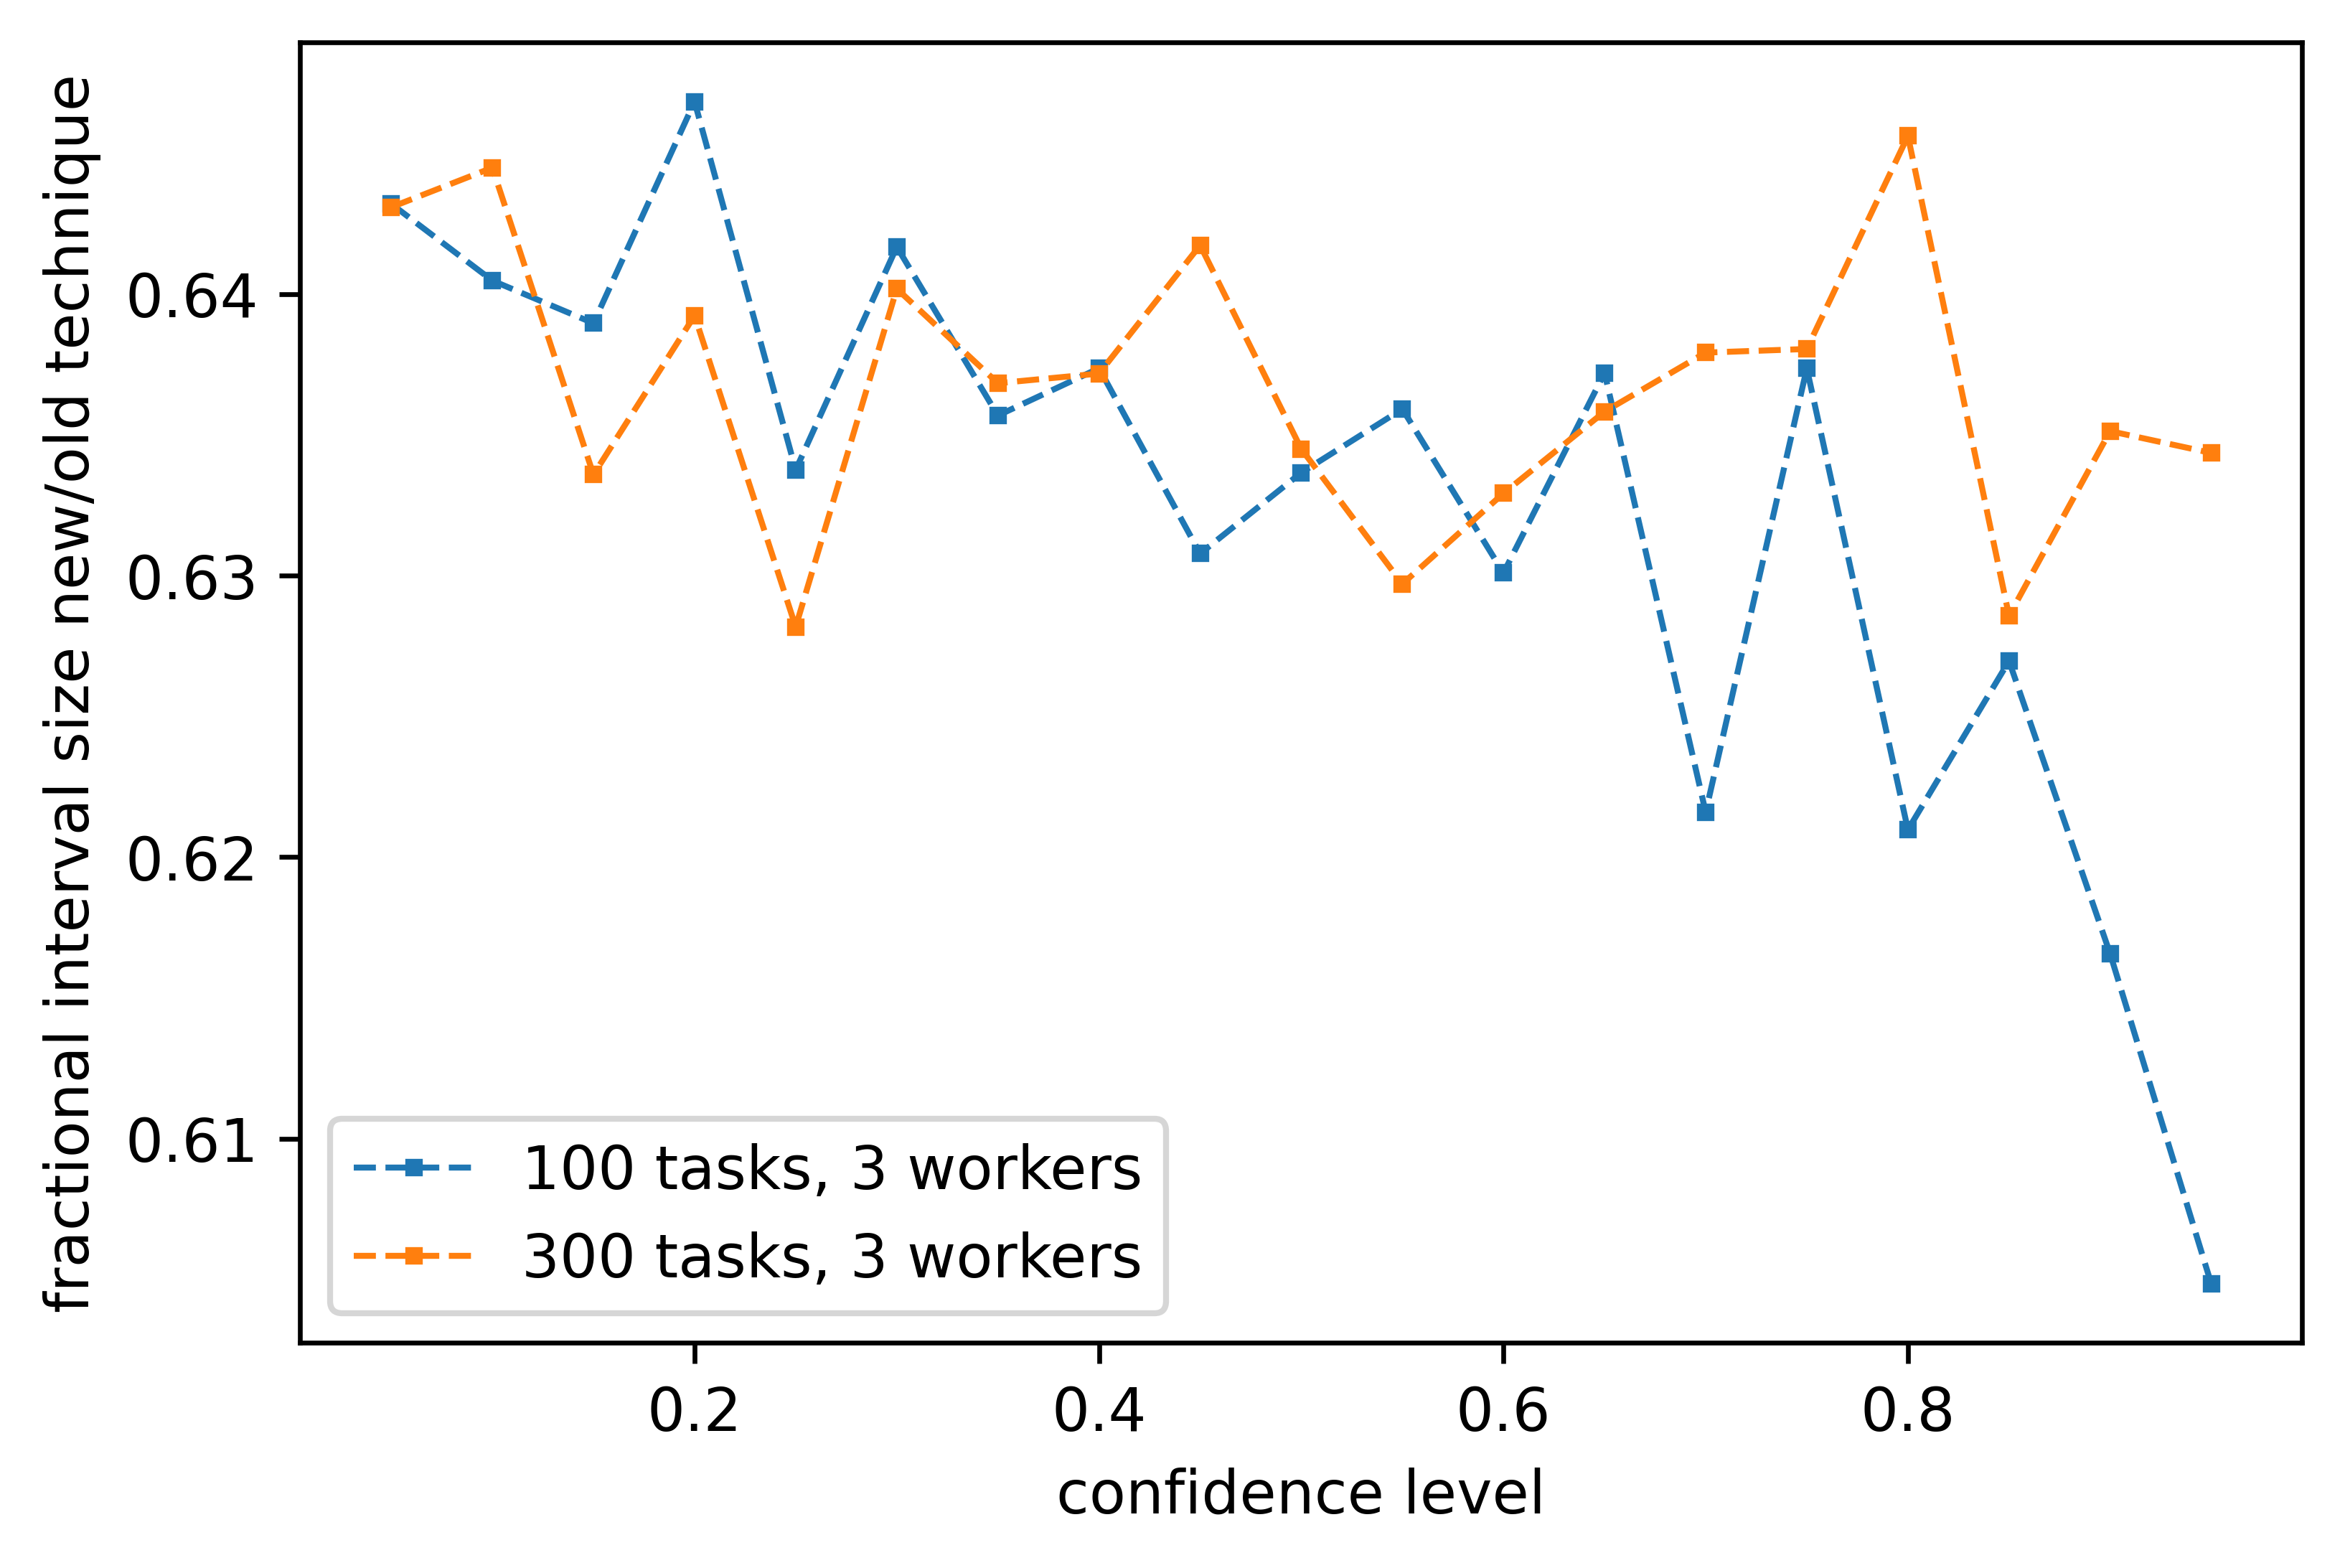

In [21]:
plt.plot(confidence_levels,
         average_interval_sizes[(100, 3)]['new'] / average_interval_sizes[(100, 3)]['old greedy'],
         label='100 tasks, 3 workers',
         marker='s', linestyle='--', linewidth=1, markersize=2)
plt.plot(confidence_levels,
         average_interval_sizes[(300, 3)]['new'] / average_interval_sizes[(300, 3)]['old greedy'],
         label='300 tasks, 3 workers',
         marker='s', linestyle='--', linewidth=1, markersize=2)
# plt.plot(confidence_levels, average_interval_sizes[(100, 3)]['new'] / average_interval_sizes[(100, 3)]['old greedy'], label='100 tasks, 3 workers')
# plt.plot(confidence_levels, average_interval_sizes[(300, 3)]['new'] / average_interval_sizes[(300, 3)]['old greedy'], label='300 tasks, 3 workers')
plt.legend()
plt.xlabel('confidence level')
plt.ylabel('fractional interval size new/old technique')